In [2]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import numpy as np


In [3]:
CHECKPOINT_FOLDER = "/home/morg/students/gottesman3/knowledge-analysis-suite/performance_by_step/"
OUTPUT_FOLDER = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks"

In [4]:
SHARED_CHECKPOINT_FOLDER = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/outputs"
SHARED_OUTPUT_FOLDER = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks"


In [5]:
def load_checkpoints(folder):
    checkpoints = {}
    for filename in os.listdir(folder):
        if filename.endswith(".json"):
            with open(os.path.join(folder, filename), "r") as f:
                data = json.load(f)
                checkpoint_name = os.path.splitext(filename)[0]
                checkpoints[checkpoint_name] = data
    return checkpoints

In [6]:
def extract_entity_data(checkpoint_data):
    records = []
    for entity_id, stats in checkpoint_data.items():
        questions = stats.get("questions", 0)
        correct = stats.get("correct", 0)
        occurences = stats.get("occurences", None)
        last_occurence = stats.get("last_occurence", None)

        if questions > 0:
            accuracy = correct / questions
            records.append({
                "entity_id": entity_id,
                "accuracy": accuracy,
                "questions": questions,
                "correct": correct,
                "occurences": occurences,
                "last_occurence": last_occurence
            })
    return pd.DataFrame(records)

In [7]:
def plot_accuracy_by_field(df, field, checkpoint_name, output_folder):
    filtered_df = df[df[field].notnull()].copy()

    shared = "shared" in output_folder

    try:
        max_val = filtered_df[field].max()
        bin_edges = np.linspace(0, max_val, num=11)  # 10 bins from 0 to max
        filtered_df["bin"] = pd.cut(
            filtered_df[field], bins=bin_edges, include_lowest=True
        )
    except ValueError:
        print(f"Could not bin '{field}' in {checkpoint_name}. Skipping.")
        return

    # Group by bin - keep empty bins
    grouped = (
        filtered_df
        .groupby("bin", observed=False)
        .agg(
            total_questions=("questions", "sum"),
            total_correct=("correct", "sum"),
            entity_count=("entity_id", "count"),
            entities=("entity_id", lambda x: list(x))
        )
        .reset_index()
    )
    grouped["accuracy"] = grouped.apply(
        lambda row: row["total_correct"] / row["total_questions"] if row["total_questions"] > 0 else 0, 
        axis=1
    )    
    grouped["bin_label"] = grouped["bin"].astype(str)
    grouped["checkpoint"] = checkpoint_name
    grouped["shared"] = shared
    grouped["performance_by"] = field

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="bin_label", y="accuracy", data=grouped)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{checkpoint_name}: Accuracy by {field} (n={len(filtered_df)})")
    plt.ylabel("Accuracy (Total Correct / Total Questions)")
    plt.xlabel(f"{field.replace('_', ' ').title()}")
    if field == "last_occurence":
        plt.ylim(0, 0.3)
    else:
        plt.ylim(0, 1.11)

    plt.grid(True, linestyle="--", alpha=0.5)

    # Annotate entity counts
    for i, row in grouped.iterrows():
        ax.text(
            i,
            row["accuracy"] + 0.03,
            f'n={row["entity_count"]}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.tight_layout()
    plot_path = os.path.join(output_folder, f"{checkpoint_name}_binned_accuracy_by_{field}.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved plot: {plot_path}")
    return grouped[["checkpoint", "shared", "performance_by", "bin_label", "accuracy", "entity_count", "entities"]]


In [8]:
def plot_occurences_of_last_seen_entities(df, checkpoint_name, output_folder):
    # Filter entities with valid last_occurence and occurences
    filtered_df = df[df["last_occurence"].notnull() & df["occurences"].notnull()].copy()
    shared = "shared" in output_folder

    try:
        max_val = filtered_df["last_occurence"].max()
        bin_edges = np.linspace(0, max_val, num=11)  # 10 bins from 0 to max
        filtered_df["last_bin"] = pd.cut(
            filtered_df["last_occurence"], bins=bin_edges, include_lowest=True
        )
    except ValueError:
        print(f"Could not bin last_occurence in {checkpoint_name}, skipping.")
        return

    # Identify the last bin
    last_bin = filtered_df["last_bin"].cat.categories[-1]
    last_seen_df = filtered_df[filtered_df["last_bin"] == last_bin].copy()


    # Define fixed bin edges
    bin_edges = [0, 10, 100, 1000, float('inf')]
    bin_labels = ['0-10', '10-100', '100-1000', '1000+']
    
    last_seen_df["occur_bin"] = pd.cut(
        last_seen_df["occurences"], 
        bins=bin_edges, 
        labels=bin_labels,
        include_lowest=True,
        right=False 
    )

    # Count how many entities fall into each occurence bin
    grouped = (
        last_seen_df
        .groupby("occur_bin", observed=True)
        .agg(entity_count=("entity_id", "count"))
        .reset_index()
    )
    grouped["bin_label"] = grouped["occur_bin"].astype(str)
    grouped["checkpoint"] = checkpoint_name
    grouped["shared"] = shared

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="bin_label", y="entity_count", data=grouped)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{checkpoint_name}: Occurence Bins of Last-Seen Entities")
    plt.ylabel("Entity Count")
    plt.xlabel("Occurences Bin")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    plot_path = os.path.join(output_folder, f"{checkpoint_name}_last_seen_entities_by_occurences.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved last-seen occurence bin plot: {plot_path}")
    return grouped[["checkpoint", "shared", "bin_label", "entity_count"]]

In [9]:
all_checkpoints_performance_checkpoints = []
all_last_bin_checkpoints = []

In [10]:
checkpoints = load_checkpoints(SHARED_CHECKPOINT_FOLDER)


In [19]:
for entity, stats in checkpoints['checkpoint_final'].items():
    print(stats)

{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0, 'occurences': 1, 'last_occurence': 43321}
{'questions': 1, 'correct': 0, 'occurences': 2, 'last_occurence': 64398}
{'questions': 1, 'correct': 0, 'occurences': 1, 'last_occurence': 85025}
{'questions': 1, 'correct': 0, 'occurences': 4, 'last_occurence': 83861}
{'questions': 1, 'correct': 0, 'occurences': 2, 'last_occurence': 93004}
{'questions': 1, 'correct': 0, 'occurences': 0, 'last_occurence': 0}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0, 'occurences': 2, 'last_occurence': 15757}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0}
{'questions': 2, 'correct': 0, 'occurences': 10, 'last_occurence': 105978}
{'questions': 1, 'correct': 0}
{'questions': 1, 'correct': 0, 'occurences': 1, 'last_occurence': 87396}
{'questions': 1, 'correct': 0}
{'qu

In [20]:
len([entity for entity, stats in checkpoints['checkpoint_final'].items() if "occurences" in stats and stats['occurences'] < 100])

9254

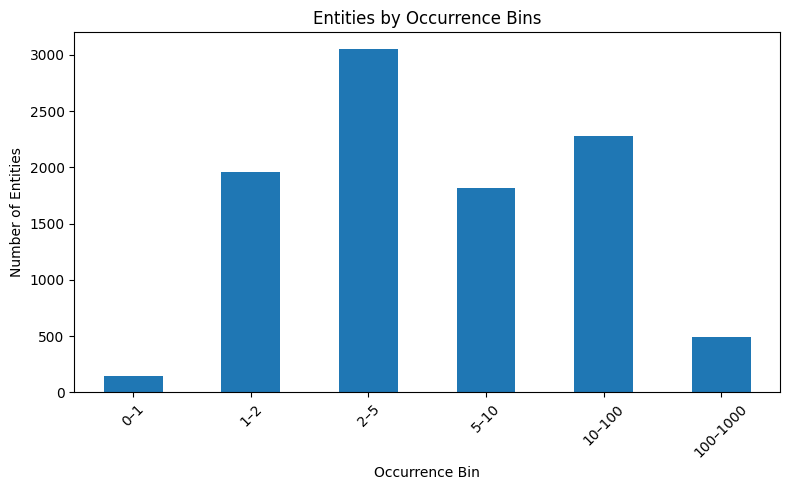

In [14]:
# Step 1: Extract occurences
entities = checkpoints['checkpoint_final']
occurences_list = [info['occurences'] for info in entities.values() if 'occurences' in info]

# Step 2: Define bins
bins = [0, 1, 2, 5, 10, 100, 1000]  # Example bin edges
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]

# Count how many occur in each bin
import pandas as pd
import numpy as np

df = pd.DataFrame({'occurences': occurences_list})
df['bin'] = pd.cut(df['occurences'], bins=bins, right=False, labels=bin_labels)

bin_counts = df['bin'].value_counts().sort_index()

# Step 3: Plot
plt.figure(figsize=(8, 5))
bin_counts.plot(kind='bar')
plt.title("Entities by Occurrence Bins")
plt.xlabel("Occurrence Bin")
plt.ylabel("Number of Entities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [97]:
checkpoints = load_checkpoints(SHARED_CHECKPOINT_FOLDER)
for checkpoint_name, checkpoint_data in checkpoints.items():
    print(f"Processing checkpoint: {checkpoint_name}")        
    df = extract_entity_data(checkpoint_data)
    if checkpoint_name == "checkpoint_final":
        final_df = df.copy()
    
    for field in ['occurences', 'last_occurence']:
        accuracy_result = plot_accuracy_by_field(df, field, checkpoint_name, SHARED_OUTPUT_FOLDER)
        all_checkpoints_performance_checkpoints.append(accuracy_result)
   
    all_last_bin_checkpoints.append(plot_occurences_of_last_seen_entities(df, checkpoint_name, SHARED_OUTPUT_FOLDER))

Processing checkpoint: checkpoint_1
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks/checkpoint_1_binned_accuracy_by_occurences.png
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks/checkpoint_1_binned_accuracy_by_last_occurence.png
Saved last-seen occurence bin plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks/checkpoint_1_last_seen_entities_by_occurences.png
Processing checkpoint: checkpoint_2
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks/checkpoint_2_binned_accuracy_by_occurences.png
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks/checkpoint_2_binned_accuracy_by_last_occurence.png
Saved last-seen occurence bin plot: /home/joberant/NLP_242

In [102]:
all_checkpoints_performance_checkpoints[0]

,checkpoint,shared,performance_by,bin_label,accuracy,entity_count,entities
0,checkpoint_2,False,occurences,"(-0.001, 19282.4]",0.022267,8826,"[Q6247345, Q5725578, Q6377295, Q5354261, Q2215..."
1,checkpoint_2,False,occurences,"(19282.4, 38564.8]",0.333333,16,"[Q65, Q90, Q9592, Q29, Q1384, Q55, Q15180, Q17..."
2,checkpoint_2,False,occurences,"(38564.8, 57847.2]",0.500000,6,"[Q60, Q38, Q148, Q408, Q668, Q16]"
3,checkpoint_2,False,occurences,"(57847.2, 77129.6]",0.083333,4,"[Q84, Q21, Q142, Q183]"
4,checkpoint_2,False,occurences,"(77129.6, 96412.0]",0.000000,0,[]
5,checkpoint_2,False,occurences,"(96412.0, 115694.4]",0.000000,1,[Q145]
6,checkpoint_2,False,occurences,"(115694.4, 134976.8]",0.000000,0,[]
7,checkpoint_2,False,occurences,"(134976.8, 154259.2]",0.000000,0,[]
8,checkpoint_2,False,occurences,"(154259.2, 173541.6]",0.000000,0,[]
9,checkpoint_2,False,occurences,"(173541.6, 192824.0]",0.000000,1,[Q30]


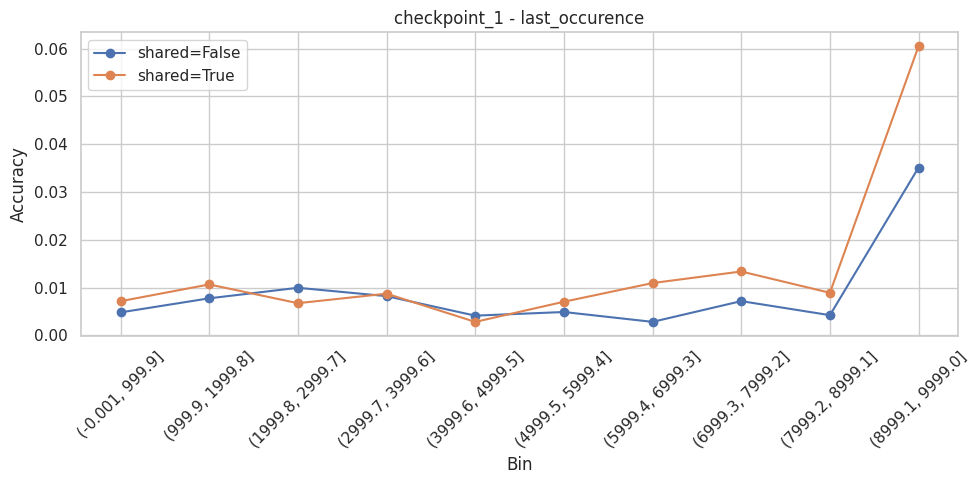

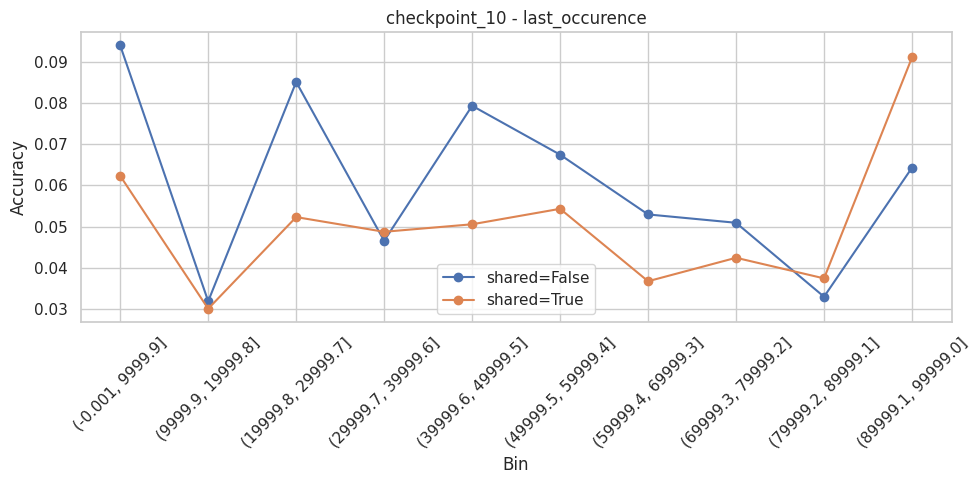

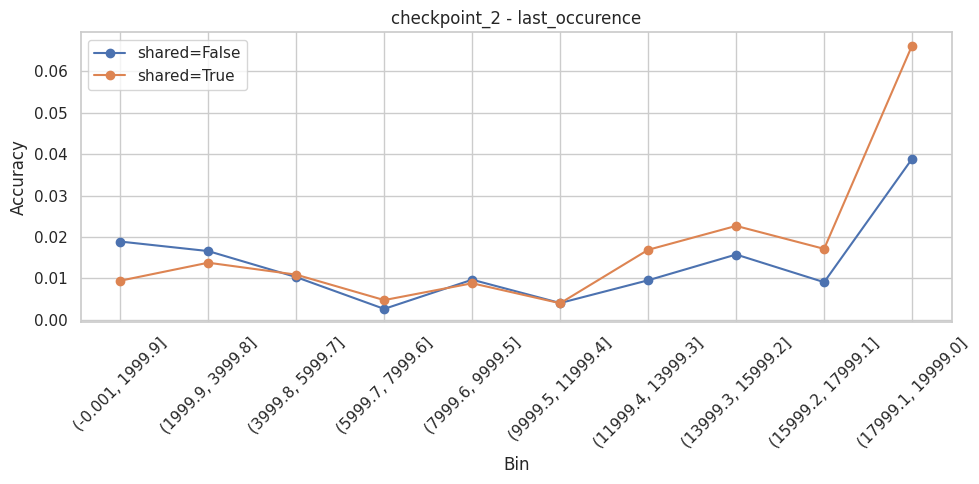

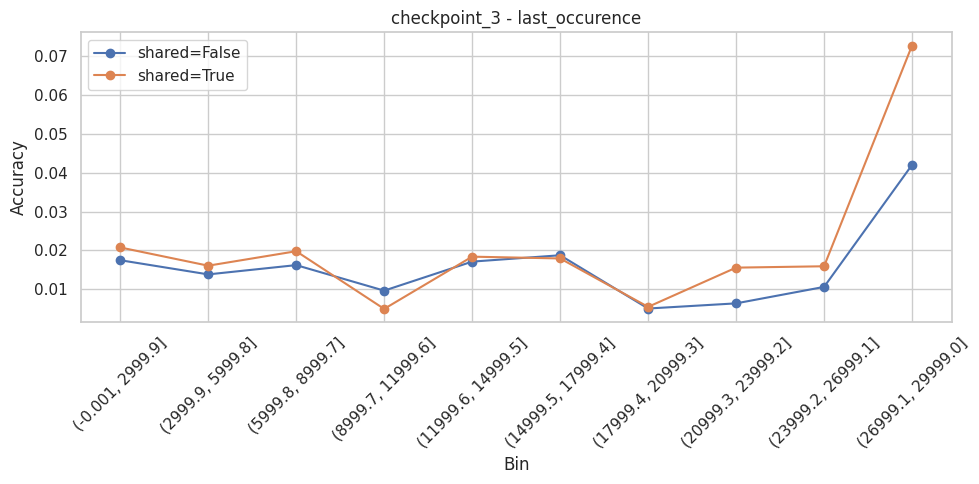

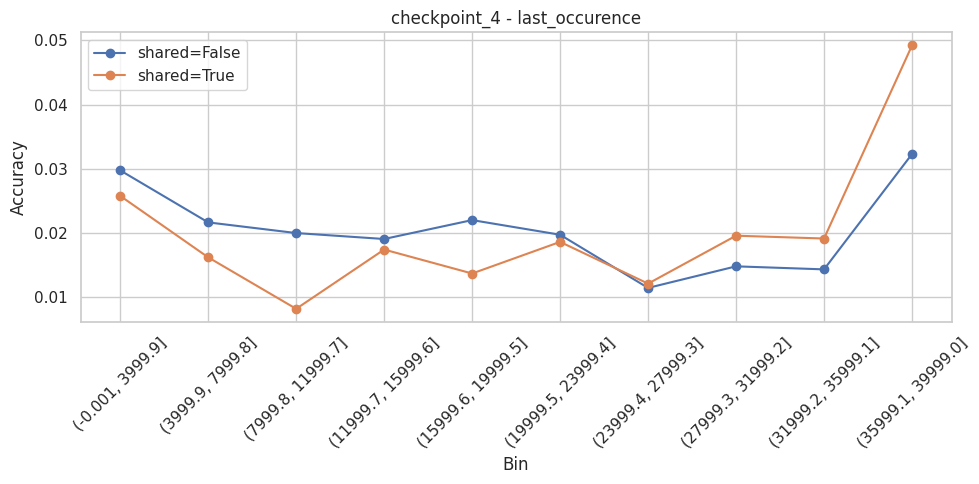

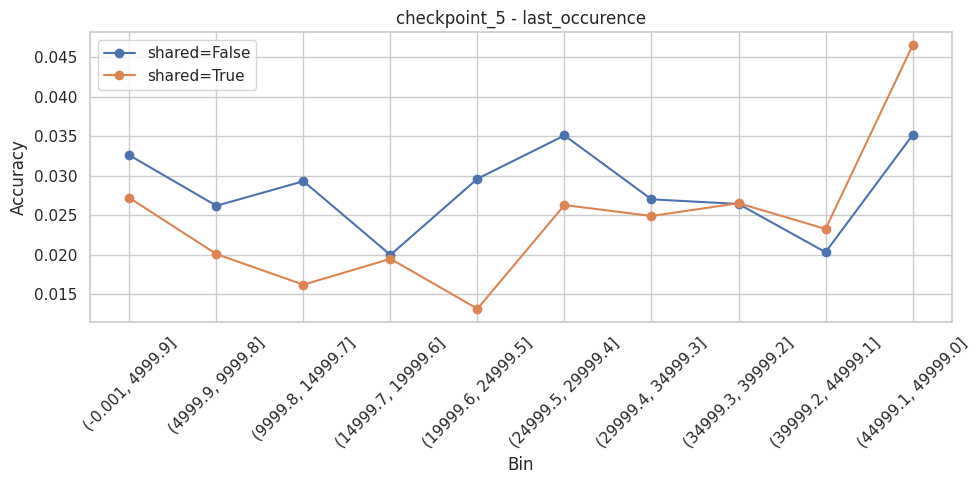

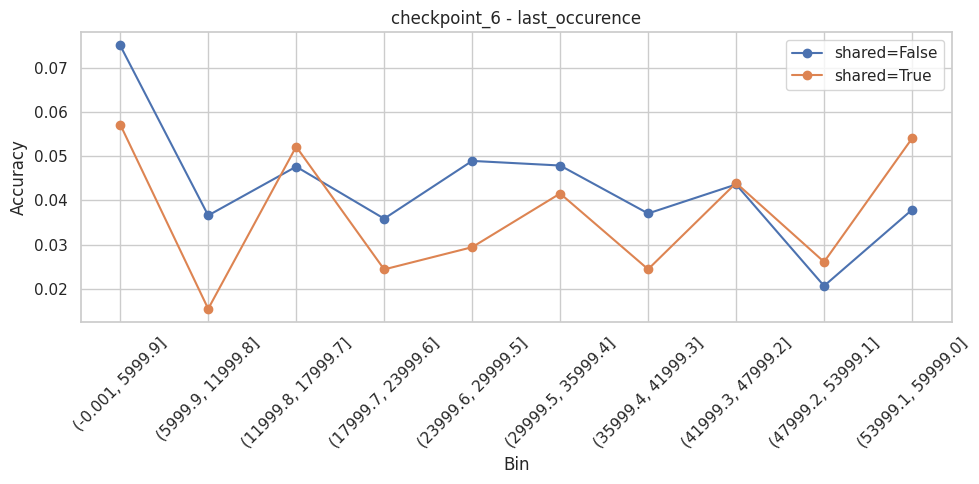

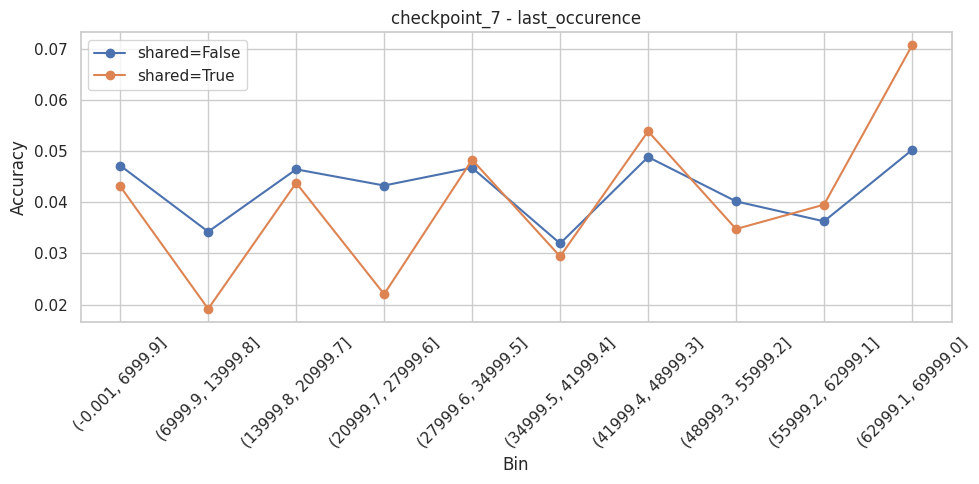

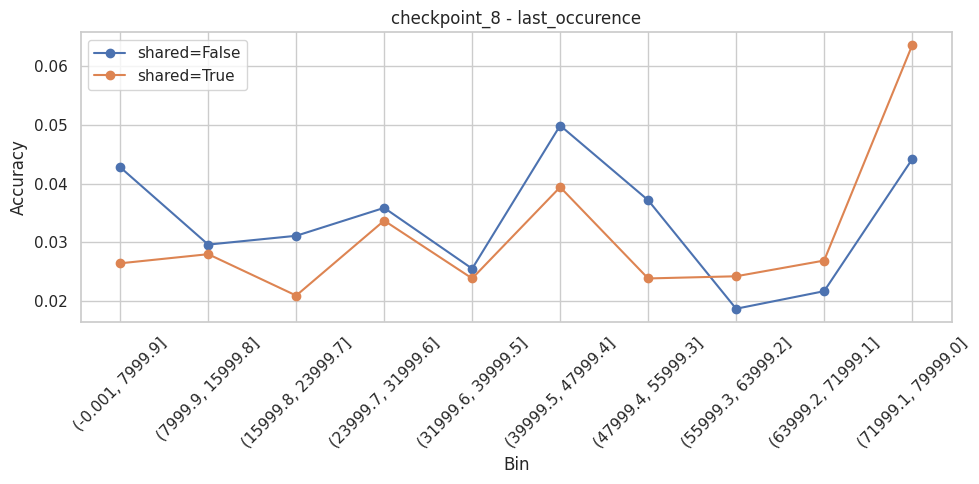

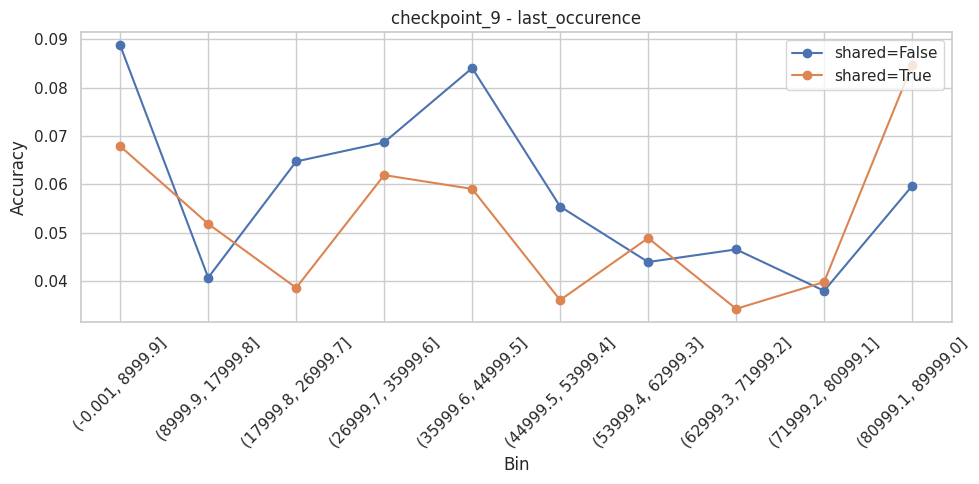

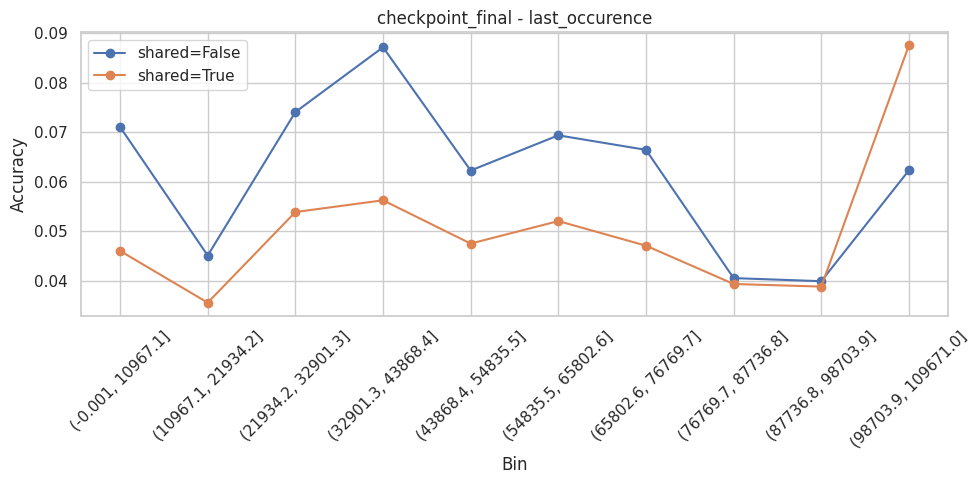

In [113]:
import matplotlib.pyplot as plt

# Combine all DataFrames
df_all = pd.concat(all_checkpoints_performance_checkpoints, ignore_index=True)

# Filter only last_occurence
df_all = df_all[df_all["performance_by"] == "last_occurence"]

# Plot per checkpoint
for checkpoint, group in df_all.groupby("checkpoint"):
    plt.figure(figsize=(10, 5))
    for shared_val, sub_group in group.groupby("shared"):
        plt.plot(
            sub_group["bin_label"].astype(str),
            sub_group["accuracy"],
            marker='o',
            label=f"shared={shared_val}"
        )
    plt.xticks(rotation=45)
    plt.title(f"{checkpoint} - last_occurence")
    plt.xlabel("Bin")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()



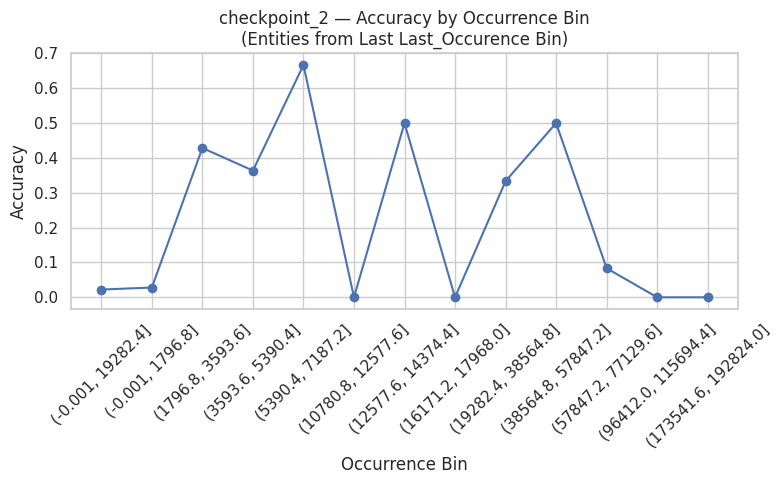

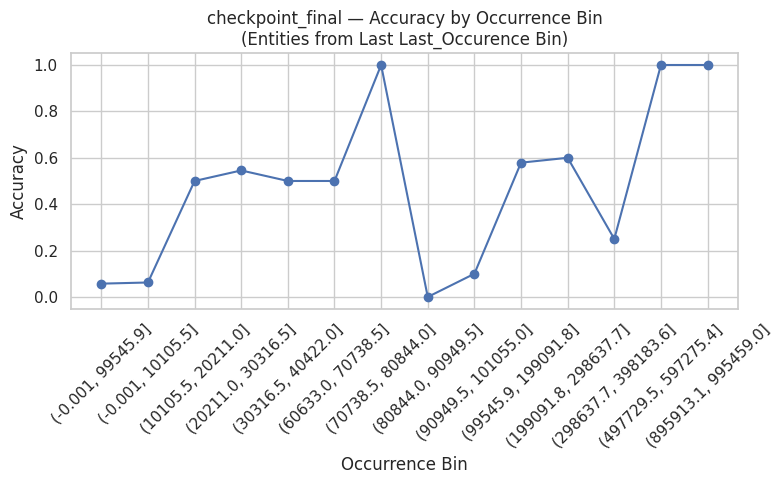

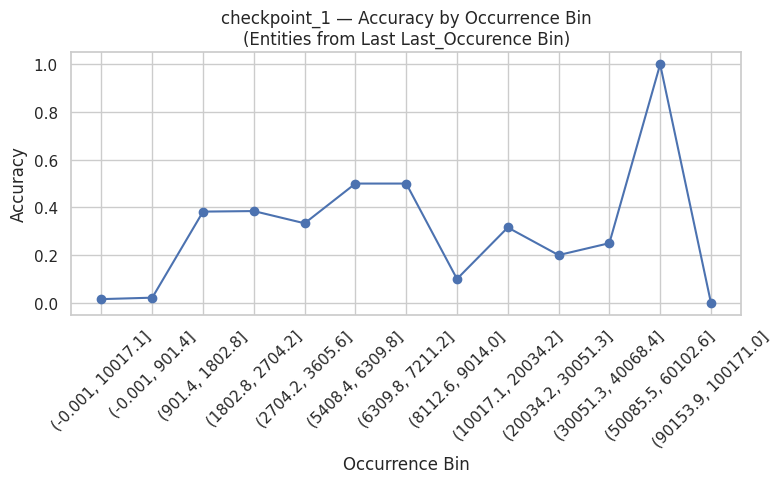

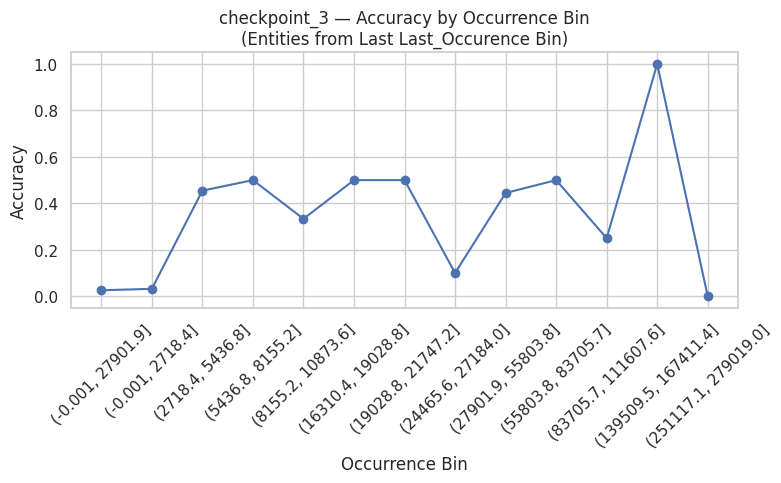

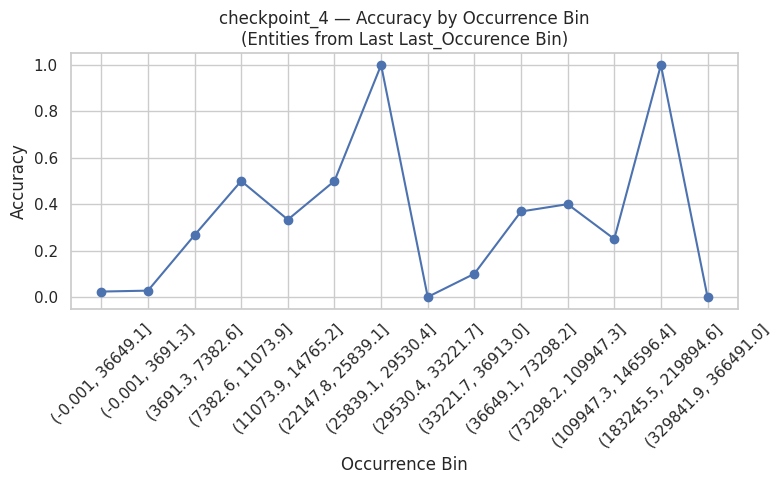

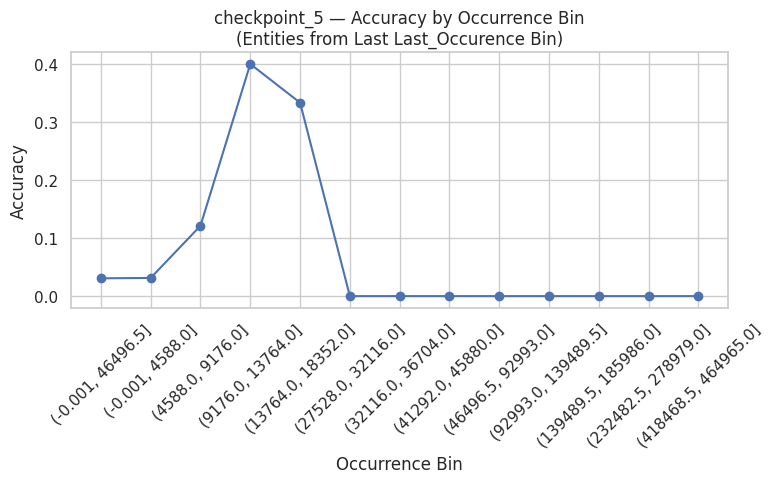

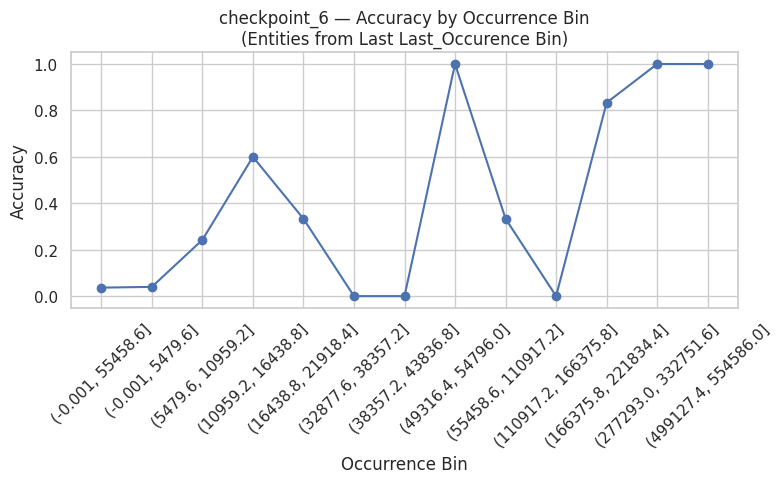

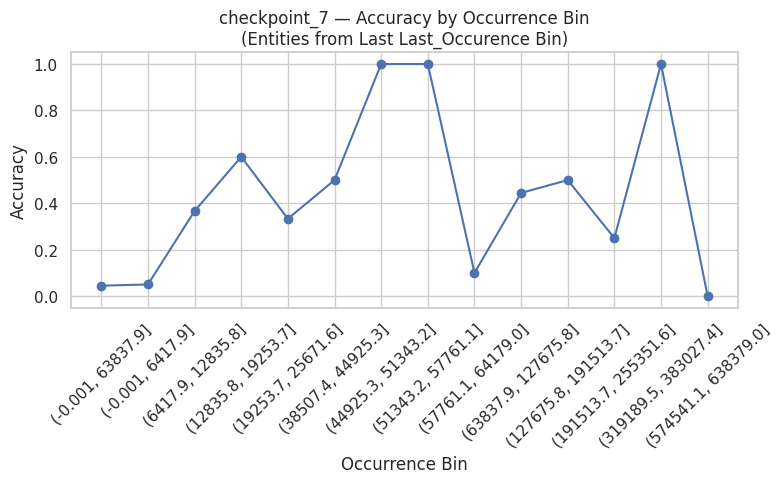

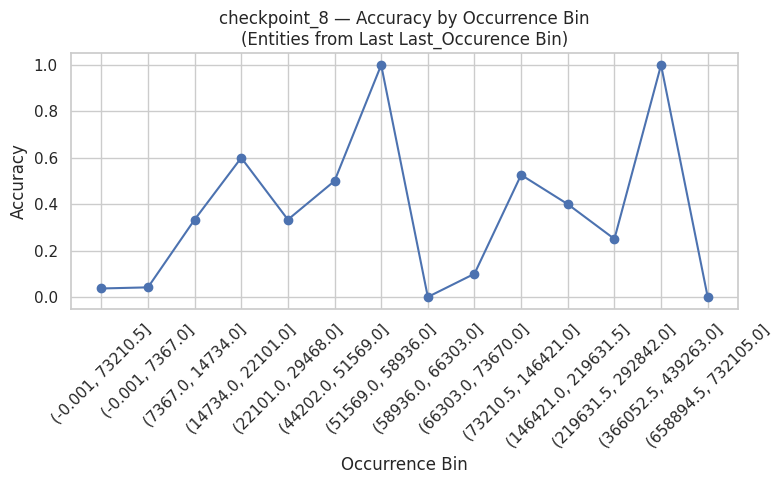

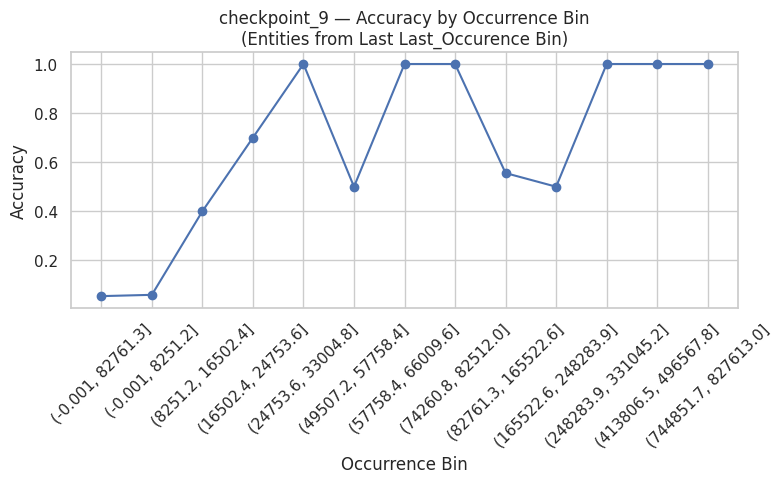

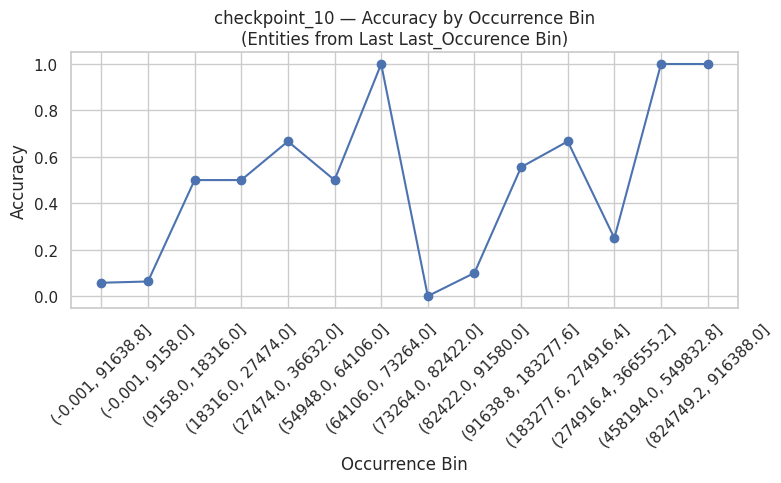

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Combine all DataFrames
df_all = pd.concat(all_checkpoints_performance_checkpoints, ignore_index=True)

# Ensure bin_label is converted to Interval (only once)
def parse_interval(s):
    nums = list(map(float, re.findall(r"[-+]?[0-9]*\.?[0-9]+", str(s))))
    return pd.Interval(left=nums[0], right=nums[1], closed="right")

df_all["bin_label"] = df_all["bin_label"].apply(parse_interval)

# For each checkpoint
for checkpoint in df_all["checkpoint"].unique():
    # Get last_occurence performance rows for this checkpoint
    last_occur_df = df_all[
        (df_all["checkpoint"] == checkpoint) &
        (df_all["performance_by"] == "last_occurence")
    ].copy()

    if last_occur_df.empty:
        continue

    # Sort by bin left edge to get the true last bin
    last_occur_df["bin_left"] = last_occur_df["bin_label"].apply(lambda x: x.left)
    last_occur_df = last_occur_df.sort_values("bin_left")

    # Get entities in the last bin
    last_bin_row = last_occur_df.iloc[-1]
    entities_in_last_bin = set(last_bin_row["entities"])

    if not entities_in_last_bin:
        continue

    # Get 'occurences' performance rows for this checkpoint
    occur_df = df_all[
        (df_all["checkpoint"] == checkpoint) &
        (df_all["performance_by"] == "occurences")
    ].copy()

    # Keep only bins that contain at least one of the relevant entities
    def has_relevant_entity(entity_list):
        return any(ent in entities_in_last_bin for ent in entity_list)

    occur_df = occur_df[occur_df["entities"].apply(has_relevant_entity)]

    if occur_df.empty:
        continue

    # Sort bins again by their left edge
    occur_df["bin_left"] = occur_df["bin_label"].apply(lambda x: x.left)
    occur_df = occur_df.sort_values("bin_left")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(
        occur_df["bin_label"].astype(str),
        occur_df["accuracy"],
        marker='o'
    )
    plt.xticks(rotation=45)
    plt.title(f"{checkpoint} — Accuracy by Occurrence Bin\n(Entities from Last Last_Occurence Bin)")
    plt.xlabel("Occurrence Bin")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()


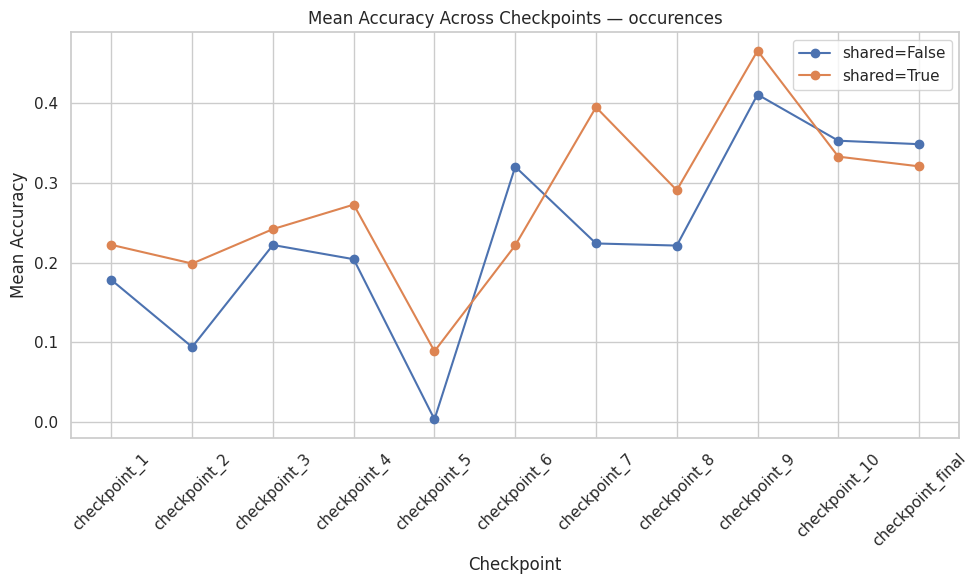

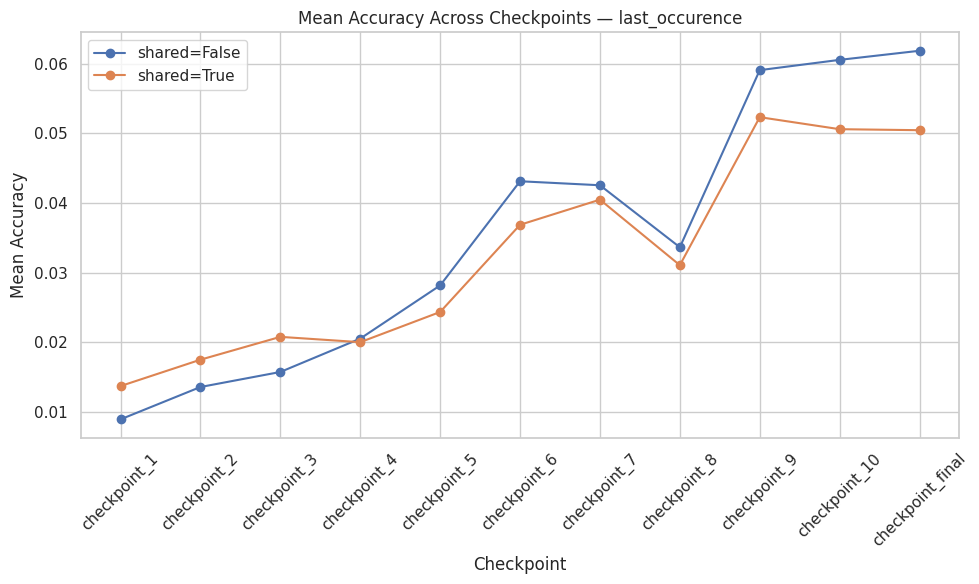

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Combine all DataFrames
df_all = pd.concat(all_checkpoints_performance_checkpoints, ignore_index=True)

# Define the exact order you want for checkpoints
desired_order = [f"checkpoint_{i}" for i in range(1, 11)] + ["checkpoint_final"]

# Map each checkpoint to its order index (for sorting)
order_map = {name: i for i, name in enumerate(desired_order)}

# Filter only checkpoints in desired order to avoid missing keys
df_all = df_all[df_all["checkpoint"].isin(order_map.keys())]

# Create a new column to sort by
df_all["checkpoint_order"] = df_all["checkpoint"].map(order_map)

for perf_type in ["occurences", "last_occurence"]:
    df_perf = df_all[df_all["performance_by"] == perf_type]

    # Aggregate mean accuracy per shared and checkpoint order
    agg_df = (
        df_perf.groupby(["shared", "checkpoint", "checkpoint_order"])
        .agg(mean_accuracy=("accuracy", "mean"))
        .reset_index()
    )

    # Sort by checkpoint order
    agg_df = agg_df.sort_values("checkpoint_order")

    plt.figure(figsize=(10, 6))
    for shared_val, group in agg_df.groupby("shared"):
        plt.plot(
            group["checkpoint"],
            group["mean_accuracy"],
            marker="o",
            label=f"shared={shared_val}"
        )

    plt.title(f"Mean Accuracy Across Checkpoints — {perf_type}")
    plt.xlabel("Checkpoint")
    plt.ylabel("Mean Accuracy")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
